In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

import models
import callbacks

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pad

import os
from typing import Optional, Literal, Dict

In [2]:
# sns.set_theme()

# Global variables

seed = 9091234 # Seeding for reproducibility
_ = pl.seed_everything(seed)

img_dir = "images"
log_dir = os.path.join(os.getcwd(), "logs")

log_name = "ls"
log_version = ""
log_path = os.path.join(log_dir, log_name, log_version)

metrics_filename = "metrics.csv"

rr_key_prefix = "residuals_ratio_"
mean_rr_key = f"{rr_key_prefix}mean"

coords_key_prefix = "coords_"

Global seed set to 9091234


# Data creation

In [3]:
n, d = 2, 10
n_estimators = 10
first_n = np.minimum(20, n_estimators)

X = torch.randn(1, n, d)
beta_bar = torch.randn(d)

y = X @ beta_bar

U, S, Vh = torch.linalg.svd(X, full_matrices=False)
lr = 1 / (4 * S.square().max())

train_data = torch.utils.data.TensorDataset(X, y, U, S, Vh)
dataloader = torch.utils.data.DataLoader(train_data, num_workers=4)

model = models.MultiLeastSquares(d=d, n_estimators=n_estimators, lr=lr)
model.init_weights_around(beta_bar)

logger = pl.loggers.CSVLogger(log_dir, name=log_name, version=log_version)
loss_es_callback = pl.callbacks.EarlyStopping(monitor="loss", patience=3, min_delta=1e-8)
es_callback = callbacks.EpsilonDifferenceEarlyStopping(monitor=mean_rr_key,
                                                       eps=1e-50,
                                                       patience=5)
rr_callback = callbacks.ResidualsRatioLoggerCallback(key_prefix=rr_key_prefix,
                                                     log_first_n_ratios=first_n)
coords_callback = callbacks.CoordinatesLoggerCallback(log_first_n_coords=first_n,
                                                      key_prefix=coords_key_prefix)
trainer = pl.Trainer(max_epochs=1_000,
                     callbacks=[loss_es_callback, es_callback, rr_callback, coords_callback],
                     enable_checkpointing=False,
                     logger=logger,
                     log_every_n_steps=1)
trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type | Params
------------------------------
------------------------------
100       Trainable params
0         Non-trainable params
100       Total params
0.000     Total estimated model params size (MB)
/home/evayness/miniforge3/envs/xp/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:186: UserWarning: Experiment logs directory /home/evayness/Documents/upmc/M1/internship/simulations/logs/ls/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

# Data processing

### Loss sanity check

In [4]:
loss_df = pad.read_csv(os.path.join(log_path, metrics_filename), usecols=["loss"])
loss = loss_df.to_numpy().squeeze()
diff = loss[:-1] - loss[1:]

# remove when close to 0
close_to_zero = np.isclose(diff, 0)
diff_bool = (diff > 0)[~close_to_zero]
print(np.stack([diff, loss[1:]], axis=1))

strict_decrease = np.all(diff_bool)

assert strict_decrease, "Loss must be decreasing."
print(f"Loss decreasing everywhere\t-> {np.all(diff > 0)}")
print(f"Loss non-increasing everywhere\t-> {np.all(diff >= 0)}")

[[2.96407227e+04 1.70730391e+04]
 [8.79760449e+03 8.27543457e+03]
 [3.23000000e+03 5.04543457e+03]
 [1.57303784e+03 3.47239673e+03]
 [9.61911621e+02 2.51048511e+03]
 [6.62879639e+02 1.84760547e+03]
 [4.79484619e+02 1.36812085e+03]
 [3.52939758e+02 1.01518109e+03]
 [2.61361267e+02 7.53819824e+02]
 [1.93940369e+02 5.59879456e+02]
 [1.44011047e+02 4.15868408e+02]
 [1.06960419e+02 3.08907990e+02]
 [7.94484558e+01 2.29459534e+02]
 [5.90144348e+01 1.70445099e+02]
 [4.38364105e+01 1.26608688e+02]
 [3.25622253e+01 9.40464630e+01]
 [2.41876144e+01 6.98588486e+01]
 [1.79668503e+01 5.18919983e+01]
 [1.33459740e+01 3.85460243e+01]
 [9.91358566e+00 2.86324387e+01]
 [7.36388779e+00 2.12685509e+01]
 [5.47003555e+00 1.57985153e+01]
 [4.06317043e+00 1.17353449e+01]
 [3.01818371e+00 8.71716118e+00]
 [2.24195051e+00 6.47521067e+00]
 [1.66535378e+00 4.80985689e+00]
 [1.23703694e+00 3.57281995e+00]
 [9.18874979e-01 2.65394497e+00]
 [6.82562351e-01 1.97138262e+00]
 [5.07016778e-01 1.46436584e+00]
 [3.766189

### Residuals ratio plotting

In [5]:
res_ratio_usecols = lambda s: rr_key_prefix in s

rr_df = pad.read_csv(os.path.join(log_path, metrics_filename), usecols=res_ratio_usecols)
res_ratio = np.fliplr(rr_df.to_numpy().squeeze())
actual_n = np.minimum(res_ratio.shape[1] - 1, first_n)

print('Least-Squares:\t', res_ratio.size, res_ratio.shape)

Least-Squares:	 1078 (98, 11)


In [6]:
rr_df

residuals_ratio_0  residuals_ratio_1  residuals_ratio_2  \
0            6.620074          34.378803           6.246087   
1            2.228043          11.570475           2.102176   
2            0.749868           3.894152           0.707506   
3            0.252375           1.310608           0.238117   
4            0.084939           0.441099           0.080140   
..                ...                ...                ...   
93           0.042788           0.088118           0.000920   
94           0.001043           0.014531           0.162664   
95           0.000570           0.088118           0.054388   
96           0.209964           0.088118           0.057522   
97           0.055900           0.014531           0.065400   

    residuals_ratio_3  residuals_ratio_4  residuals_ratio_5  \
0            0.317361           2.991726           0.640800   
1            0.106811           1.006894           0.215667   
2            0.035948           0.338878           0.072585   
3            0.012099           0.114054           0.024429   
4            0.004072           0.038385           0.008222   
..                ...                ...                ...   
93           0.050423           0.039425           0.000339   
94           0.057522           0.426745           0.004016   
95           0.063190           0.186865           0.017266   
96           0.065400           0.000006           0.011053   
97           0.067804           0.262747           0.001896   

    residuals_ratio_6  residuals_ratio_7  residuals_ratio_8  \
0            0.278245           0.590153           0.113340   
1            0.093646           0.198621           0.038145   
2            0.031517           0.066848           0.012838   
3            0.010607           0.022498           0.004321   
4            0.003570           0.007572           0.001454   
..                ...                ...                ...   
93           0.032564           0.006171           0.005132   
94           0.002371           0.013372           0.001944   
95           0.016431           0.030755           0.003759   
96           0.021709           0.036883           0.007394   
97           0.000516           0.002556           0.019260   

    residuals_ratio_9  residuals_ratio_mean  
0            0.669232              5.284582  
1            0.225236              1.778571  
2            0.075805              0.598595  
3            0.025513              0.201462  
4            0.008587              0.067804  
..                ...                   ...  
93           0.003703              0.026958  
94           0.002170              0.068638  
95           0.000016              0.046136  
96           0.007701              0.050575  
97           0.000293              0.049090  

[98 rows x 11 columns]

In [7]:
tail = rr_df.tail(1).to_numpy()[0]
unique = np.unique(tail[:-1])
counts = [(tail[:-1] == u).sum() for u in unique]

for u, c in zip(unique, counts):
    print(f"{u}\t-> {c}")

0.0002925205044448	-> 1
0.0005159859429113	-> 1
0.0018956714775413	-> 1
0.0025557361077517	-> 1
0.0145307211205363	-> 1
0.0192601010203361	-> 1
0.055899504572153	-> 1
0.0653998181223869	-> 1
0.0678043887019157	-> 1
0.2627471387386322	-> 1


In [8]:
def get_color_cycler_for(n: int, cmap: str = "cool"):
    from cycler import cycler
    
    colors = matplotlib.colormaps[cmap]
    color_cycler = cycler("color", [colors(alpha) for alpha in np.linspace(0, 1, n)])
    return color_cycler

In [9]:
fig, ax = plt.subplots(layout="tight")

ax.set_ylabel("log residuals ratio")
# ax1.set_title("Quadratic setting")
if actual_n > 0:
    ax.set_prop_cycle(get_color_cycler_for(actual_n))
    ax.plot(np.log10(res_ratio[:, 1:actual_n+1]), alpha=0.6, ls='--')
    ax.set_prop_cycle(None)

ax.plot(np.log10(res_ratio[:, 0]), label="mean")

ax.legend()
ax.grid("on")

path = os.path.join(img_dir, "ls_log_residuals_ratio_pl.pdf")
fig.savefig(path)
plt.show()

### Trajectories plotting

In [10]:
coords_usecols = lambda s: coords_key_prefix in s
coords_df = pad.read_csv(os.path.join(log_path, metrics_filename), usecols=coords_usecols)

all_coords = torch.tensor(coords_df.to_numpy().squeeze())
all_coords = all_coords.reshape(all_coords.shape[0], first_n, n)
all_coords = all_coords.mT.numpy() # all_coords[iter, dim, traj]

print(all_coords.shape)

(98, 2, 10)


In [11]:
beta_star = X[0].T @ (X[0] @ X[0].T).inverse() @ y[0]
proj_beta_star = Vh[0] @ beta_star
print(fr"Projected \beta^\star: {proj_beta_star} ({torch.isclose(proj_beta_star, Vh[0] @ beta_bar)}).")

Projected \beta^\star: tensor([-1.1157,  0.3847]) (tensor([True, True])).


In [12]:
mean_close = (torch.tensor(all_coords).mean(axis=2)).type_as(proj_beta_star).isclose(proj_beta_star)

mixed_mean_close = mean_close[:, 0] & mean_close[:, 1]
first_close = np.argmax(mixed_mean_close)

x1_estimate = all_coords[first_close - 1, 0].mean()
x2_estimate = all_coords[first_close - 1, 1].mean()
print(f"At index {first_close.item()}, estimators are close from the solution.")

approach = torch.tensor([proj_beta_star[0] - x1_estimate, proj_beta_star[1] - x2_estimate])
unit_approach = approach / approach.norm()
print(f"Mean approach unit vector: {unit_approach}.")

At index 92, estimators are close from the solution.
Mean approach unit vector: tensor([0.0797, 0.9968]).


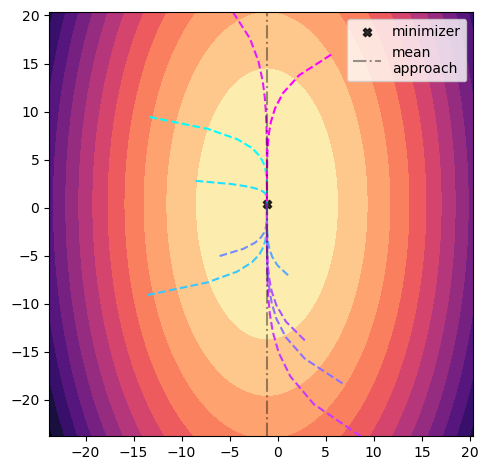

In [13]:
m, M = np.amin(all_coords), np.amax(all_coords)
divs = int((M - m)*20)+1
contour_levels = 15

xv, yv = np.meshgrid(np.linspace(m, M, divs), np.linspace(m, M, divs))
zv = np.stack([xv, yv], axis=-1).reshape(divs * divs, 2)

zs = np.square(y - (U[0] @ torch.diag(S[0]) @ zv.T).T).sum(axis=1).reshape(divs, divs)

fig, ax = plt.subplots(layout="tight")

# Loss contour levels
ax.contourf(xv, yv, zs, contour_levels, cmap=matplotlib.cm.magma_r)

# Trajectories
ax.set_prop_cycle(get_color_cycler_for(actual_n))
ax.plot(all_coords[:,0,:], all_coords[:,1,:], ls='--') #, label=[f"Traj {k+1}" for k in range(ls_first_n)])
ax.set_prop_cycle(None)
ax.scatter([proj_beta_star[0]], [proj_beta_star[1]], marker='X', color='black', alpha=.8, label="minimizer")

# Axis and mean approach
# ax.axline((0, 0), (U[0, 0, 0], U[0, 1, 0]), color='red', label=r"$U_{:0}$", alpha=.4)
# ax.axline((0, 0), (U[0, 0, 1], U[0, 1, 1]), color='green', label=r"$U_{:1}$", alpha=.4)
ax.axline(proj_beta_star, (x1_estimate, x2_estimate), ls='-.', color='black', label="mean\napproach", alpha=.4)

ax.set_aspect("equal", "box")
ax.legend()

# ax.set_xlim(proj_beta_star[0]-.1, proj_beta_star[0]+.1)
# ax.set_ylim(proj_beta_star[1]-.1, proj_beta_star[1]+.1)

path = os.path.join(img_dir, "ls_gd_trajectories_pl.pdf")
fig.savefig(path)
plt.show()